# Pipeline example, mortality

This notebook uses the same demographic components as `pipeline_001_mortality`, and it runs five simulations in parallel using `multiprocessing`.

In [1]:
import datetime
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import Mortality
from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import build_mortality_table
from vivarium_public_health.population.spenser_population import transform_mortality_table
from vivarium_public_health.population.spenser_population import prepare_dataset

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):        
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_mortality_file': inp_file['paths']['path_to_mortality_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## All steps required to do one simulation

In [4]:
def run_simulation(mortality_multiply=1.):
    inp_file = read_config_file("../config/model_specification.yaml")

    base_plugins = base_plugins_simulation()
    config = config_simulation(inp_file=inp_file)
    components = [eval(x) for x in inp_file["list_components"]]
    simulation = InteractiveContext(components=components,
                                    configuration=config,
                                    plugin_configuration=base_plugins,
                                    setup=False)

    df = pd.read_csv(config.path_to_mortality_file)
    # to save time, only look at locatiosn existing on the test dataset.
    mortality_rate_df = df[(df['LAD.code']=='E08000032')]

    asfr_data = transform_mortality_table(mortality_rate_df,
                                          2011,
                                          2012,
                                          config.population.age_start,
                                          config.population.age_end)
    
    asfr_data["mean_value"] *= mortality_multiply
    simulation._data.write("cause.all_causes.cause_specific_mortality_rate", asfr_data)
    print(f"Simulation set up -- {multiprocessing.current_process().name}")
    simulation.setup()
    num_days = 365*2 + 10
    simulation.run_for(duration=pd.Timedelta(days=num_days))
    pop = simulation.get_population()
    return pop

In [5]:
# Prepare the data only once
inp_file = read_config_file("../config/model_specification.yaml")

if inp_file['prepare_data']['prepare']:
    # read a dataset (normally from daedalus), change columns to be readable by vivarium
    # this function creates a file saved at output_path
    prepare_dataset(
        dataset_path=inp_file['prepare_data']['path_to_dataset'], 
        output_path=inp_file['prepare_data']['path_to_output'],
        lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
        columns_map=inp_file['prepare_data']['columns_map'],
        location_code=inp_file['prepare_data']['location_code']
        )




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Simulations

Five simulations are defined by `mortality_multiply_list = [0.5, 0.8, 1, 1.2, 2]` (next cell). In this example, all the input mortality rates are multiplied by 0.5, 0.8, 1, 1.2 and 2, respectively. 

In [6]:
sim_start = time.time()

mortality_multiply_list = [0.5, 0.8, 1, 1.2, 2]

proc_pool = multiprocessing.Pool(6)
results = proc_pool.map(run_simulation, (mortality_multiply_list))
proc_pool.close()
proc_pool.join()

sim_end = time.time()

Simulation set up -- ForkPoolWorker-5


2020-07-01 09:57:09.549 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics


Simulation set up -- ForkPoolWorker-3


2020-07-01 09:57:09.588 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics


Simulation set up -- ForkPoolWorker-4


2020-07-01 09:57:09.602 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics


Simulation set up -- ForkPoolWorker-2


2020-07-01 09:57:09.623 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics


Simulation set up -- ForkPoolWorker-1


2020-07-01 09:57:09.640 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-07-01 09:57:14.257 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-01 09:57:14.261 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics
2020-07-01 09:57:14.363 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-01 09:57:14.368 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics
2020-07-01 09:57:14.472 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-01 09:57:14.475 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-01 09:57:14.477 | DEBUG  

2020-07-01 09:58:33.731 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-07-01 09:58:36.357 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00


2020-07-01 09:58:37.469 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00


2020-07-01 09:58:37.804 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00


2020-07-01 09:58:38.157 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00


2020-07-01 09:58:38.179 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-07-01 09:58:38.383 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-07-01 09:58:39.406 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-07-01 09:58:39.727 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-07-01 09:58:40.061 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-07-01 09:58:40.069 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-07-01 09:58:40.282 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-31 00:00:00
2020-07-01 09:58:41.271 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-07-01 09:58:41.714 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-07-01 09:58:42.030 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-07-01 09:58:42.038 | DEBUG    | vivarium.framework.engi

2020-07-01 09:59:13.142 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-30 00:00:00
2020-07-01 09:59:13.679 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-30 00:00:00
2020-07-01 09:59:13.797 | DEBUG    | vivarium.framework.engine:step:140 - 2011-06-30 00:00:00
2020-07-01 09:59:13.867 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-20 00:00:00
2020-07-01 09:59:14.629 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-10 00:00:00
2020-07-01 09:59:14.957 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-10 00:00:00
2020-07-01 09:59:15.623 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-10 00:00:00
2020-07-01 09:59:15.746 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-10 00:00:00
2020-07-01 09:59:15.801 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-30 00:00:00
2020-07-01 09:59:16.572 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-20 00:00:00
2020-07-01 09:59:16.881 | DEBUG    | vivarium.framework.engi

2020-07-01 09:59:45.107 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-17 00:00:00
2020-07-01 09:59:45.915 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-27 00:00:00
2020-07-01 09:59:46.132 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-27 00:00:00
2020-07-01 09:59:47.022 | DEBUG    | vivarium.framework.engine:step:140 - 2012-01-16 00:00:00
2020-07-01 09:59:47.067 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-27 00:00:00
2020-07-01 09:59:47.092 | DEBUG    | vivarium.framework.engine:step:140 - 2011-12-27 00:00:00
2020-07-01 09:59:48.066 | DEBUG    | vivarium.framework.engine:step:140 - 2012-01-06 00:00:00
2020-07-01 09:59:48.269 | DEBUG    | vivarium.framework.engine:step:140 - 2012-01-06 00:00:00
2020-07-01 09:59:48.902 | DEBUG    | vivarium.framework.engine:step:140 - 2012-01-06 00:00:00
2020-07-01 09:59:48.918 | DEBUG    | vivarium.framework.engine:step:140 - 2012-01-26 00:00:00
2020-07-01 09:59:48.943 | DEBUG    | vivarium.framework.engi

2020-07-01 10:00:17.587 | DEBUG    | vivarium.framework.engine:step:140 - 2012-06-14 00:00:00
2020-07-01 10:00:17.600 | DEBUG    | vivarium.framework.engine:step:140 - 2012-07-04 00:00:00
2020-07-01 10:00:17.739 | DEBUG    | vivarium.framework.engine:step:140 - 2012-06-14 00:00:00
2020-07-01 10:00:18.887 | DEBUG    | vivarium.framework.engine:step:140 - 2012-06-24 00:00:00
2020-07-01 10:00:19.158 | DEBUG    | vivarium.framework.engine:step:140 - 2012-06-24 00:00:00
2020-07-01 10:00:19.313 | DEBUG    | vivarium.framework.engine:step:140 - 2012-06-24 00:00:00
2020-07-01 10:00:19.373 | DEBUG    | vivarium.framework.engine:step:140 - 2012-07-14 00:00:00
2020-07-01 10:00:19.492 | DEBUG    | vivarium.framework.engine:step:140 - 2012-06-24 00:00:00
2020-07-01 10:00:20.641 | DEBUG    | vivarium.framework.engine:step:140 - 2012-07-04 00:00:00
2020-07-01 10:00:20.948 | DEBUG    | vivarium.framework.engine:step:140 - 2012-07-04 00:00:00
2020-07-01 10:00:21.063 | DEBUG    | vivarium.framework.engi

2020-07-01 10:00:52.064 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-11 00:00:00
2020-07-01 10:00:52.182 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-11 00:00:00
2020-07-01 10:00:52.287 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-11 00:00:00
2020-07-01 10:00:52.413 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-31 00:00:00
2020-07-01 10:00:52.491 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-11 00:00:00
2020-07-01 10:00:53.830 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-21 00:00:00
2020-07-01 10:00:54.016 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-21 00:00:00
2020-07-01 10:00:54.058 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-21 00:00:00
2020-07-01 10:00:54.295 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-21 00:00:00
2020-07-01 10:00:55.510 | DEBUG    | vivarium.framework.engine:step:140 - 2012-12-31 00:00:00
2020-07-01 10:00:55.713 | DEBUG    | vivarium.framework.engi

In [7]:
len(results)

5

In [8]:
print(f"Total time: {sim_end - sim_start}")
for i, pop in enumerate(results):
    print("----")
    print(mortality_multiply_list[i])
    print (f'#alive: {len(pop[pop["alive"]=="alive"])}')
    print (f'#dead: {len(pop[pop["alive"]!="alive"])}')

Total time: 229.27352809906006
----
0.5
#alive: 518002
#dead: 4419
----
0.8
#alive: 515342
#dead: 7079
----
1
#alive: 513679
#dead: 8742
----
1.2
#alive: 512146
#dead: 10275
----
2
#alive: 506197
#dead: 16224


## Plot results

In [9]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2012-12-31", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

min_time: 2011-01-01
max_time: 2012-12-31 00:00:00


In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

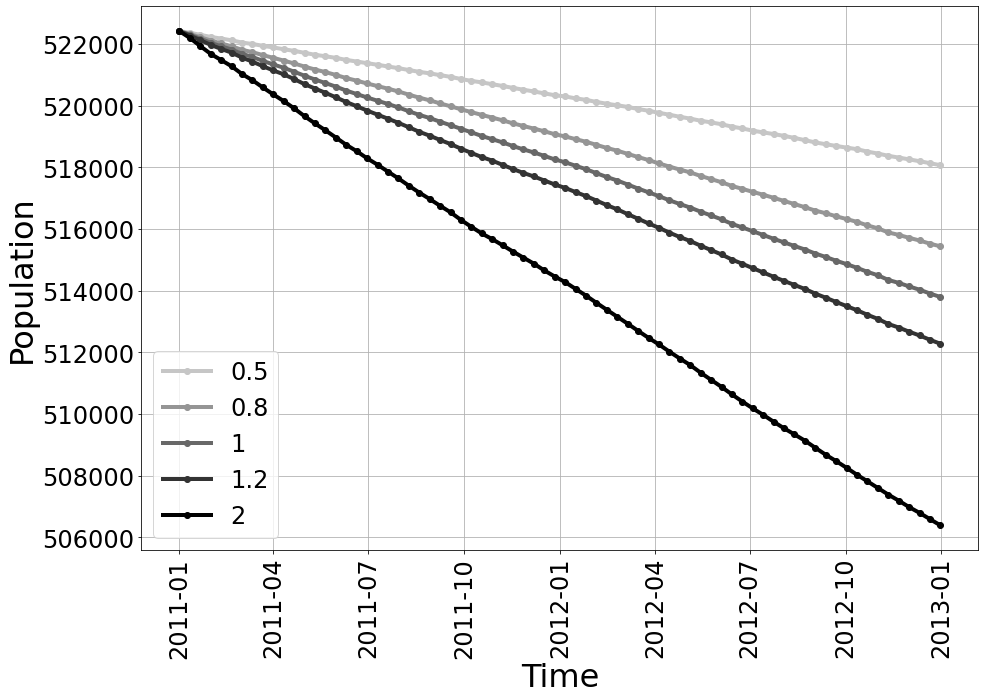

In [11]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

pop = results[0]
plt.figure(figsize=(15, 10))

cmap = plt.get_cmap('Greys')
colors = [cmap(i) for i in np.linspace(0, 1, len(results)+2)]

for i, pop in enumerate(results):
    # Population (total, for selected ethnicities, gender)
    total_population = len(pop)
    total_population_ETH = len(pop[pop["ethnicity"].isin(sel_ethnicity)])
    total_population_male = len(pop[pop["sex"] == 1])
    total_population_female = len(pop[pop["sex"] == 2])

    time_axis = []
    population_axis = []
    population_ETH_axis = []
    population_M_axis = []
    population_F_axis = []

    curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")

    
    
    while curr_time <= max_time:
        time_axis.append(curr_time)

        # dead population until current time (changes in the while loop)
        pop_dead = pop[pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]

        num_dead_population = total_population - len(pop_dead)
        population_axis.append(num_dead_population)

        num_dead_population_eth = total_population_ETH - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
        population_ETH_axis.append(num_dead_population_eth)

        num_dead_male = total_population_male - len(pop_dead[pop_dead["sex"] == 1])
        population_M_axis.append(num_dead_male)

        num_dead_female = total_population_female - len(pop_dead[pop_dead["sex"] == 2])
        population_F_axis.append(num_dead_female)

        # go to next time, according to the selected interval_in_days
        curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
        curr_time += datetime.timedelta(days=interval_in_days)

    # Population (total)
    plt.plot(time_axis, population_axis, 
             c=colors[i+2], lw=4, marker="o", 
             label=f"{mortality_multiply_list[i]}"
            )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()